In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import struct as st

import os

import matplotlib.pyplot as plt
%matplotlib inline

### Loading from ubyte files
actually we don't have enough working memory

In [2]:
# filename = "data/fashion"+ os.listdir("data/fashion")[0]
dirname = "data/fashion/"

In [3]:
files = os.listdir(dirname)
files

['t10k-images-idx3-ubyte.gz',
 't10k-images.idx3-ubyte',
 't10k-labels-idx1-ubyte.gz',
 't10k-labels.idx1-ubyte',
 'train-images-idx3-ubyte.gz',
 'train-images.idx3-ubyte',
 'train-labels-idx1-ubyte.gz',
 'train-labels.idx1-ubyte']

In [4]:
testing_set = {"img": dirname+files[1], "label":dirname+files[3]}
training_set = {"img": dirname+files[5], "label":dirname+files[5]}

In [5]:
testing_set

{'img': 'data/fashion/t10k-images.idx3-ubyte',
 'label': 'data/fashion/t10k-labels.idx1-ubyte'}

In [6]:
testing_set_img = open(testing_set["img"], "rb")

To change the file object’s position, use f.seek(offset, whence). The position is computed from adding offset to a reference point; the reference point is selected by the whence argument. A whence value of 0 measures from the beginning of the file, 1 uses the current file position, and 2 uses the end of the file as the reference point. whence can be omitted and defaults to 0, using the beginning of the file as the reference point.



In [67]:
testing_set_img.seek(0)
# --> go to the first byte of the file

0

In [32]:
st.calcsize("4B")

4

In [65]:
# https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1

In [23]:
magic = st.unpack(">4B", testing_set_img.read(4))

In [26]:
magic


(0, 0, 8, 3)

In [72]:
# should do this right after the seek method to be sure that we are starting at the beginning of the document
testing_set_img.seek(0)

nimg = st.unpack(">I", testing_set_img.read(4))[0]
nrow = st.unpack(">I", testing_set_img.read(4))[0]
ncol = st.unpack(">I", testing_set_img.read(4))[0]

In [63]:
test_img = np.zeros((nimg,nrow,ncol))

In [73]:
# 1 pixel is 1 byte so:
nbytes = nimg*nrow*ncol*1
nbytes

574280000

In [80]:
# memory leak with this huge buffer.........

In [79]:
# img = 255 - np.asarray(st.unpack(">"+"B"*nbytes, testing_set_img.read(nbytes))).reshape((nimg, nrow, ncol))

In [ ]:
# data is big endian --> ">"
#  use integer type B, which is of size = 1

### Loading data using something else...:

In [2]:
import tensorflow as tf

C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\ten

### MNIST digits

In [104]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#### Take a look at one image and its label

5


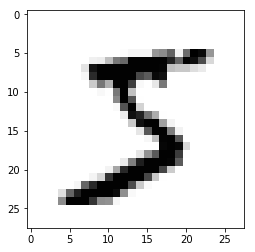

In [10]:
print(y_train[0])
plt.imshow(x_train[0], cmap = "Greys")

In [11]:
from sklearn.preprocessing import MinMaxScaler

#### Normalize values

In [111]:
mmScaler = MinMaxScaler()
# mmScaler.fit([0,255])

assert(x_train[0].reshape(-1).reshape(28,28).all() == x_train[0].all())
# so we can flatten and unflatten to min-max scale even though this is probably not ideal


x_train_norm = mmScaler.fit_transform(x_train.reshape(x_train.shape[0], -1).astype("float64")).reshape(x_train.shape)
x_test_norm = mmScaler.fit_transform(x_test.reshape(x_test.shape[0], -1).astype("float64")).reshape(x_test.shape)

x_train_norm_int = x_train_norm.astype(x_train.dtype)
x_test_norm_int = x_test_norm.astype(x_train.dtype)

####  distribution of pixels:

C:\Users\theop\Anaconda3\envs\env_ipynb\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


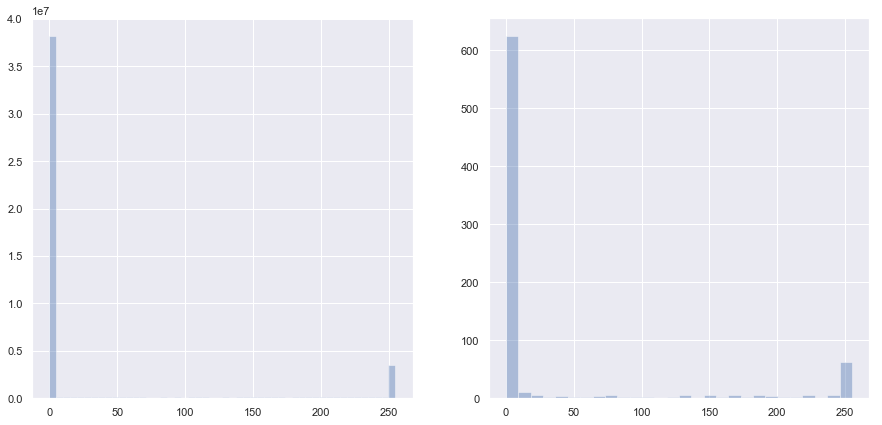

In [18]:
sns.set()
fig, ax = plt.subplots(figsize = (15,7), ncols = 2)
sns.distplot(a = x_train.reshape(-1), kde = False, ax = ax[0])
sns.distplot(a = x_train.reshape(x_train.shape[0],-1)[0], kde = False, ax = ax[1])

we can see that there are mostly just values corresponding to 0 and 255, so we could decide to not convert all the values in between to doubles but to ints --> all values are set to max or min (0 or 1 after min max scaling)

we can then see if it makes any difference. Usually it won't as the network should already be able to attain high accuracy wihtout any processing. Plus the images are already centered and well calibrated, so its not like they need that much pre processing. 

We should also investigate with / without rotations to see what that does.


normalizing: we know values are between 0 and 255 because 256 color grading. We will use a min-max scaler, with the min being 0 and the max being 255 then

we can also one hot encode the labels, but that can be taken care of by keras when using "sparse" instead of regular categorical cross entropy

#### One hot encode labels 

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
# since there are 10 different classes (hint: numbers from 0 to 9 included)
y_train_enc = to_categorical(y_train, 10)
y_test_enc = to_categorical(y_test, 10)

#### class distribution

Need to make sure the classes are more or less balanced before we train

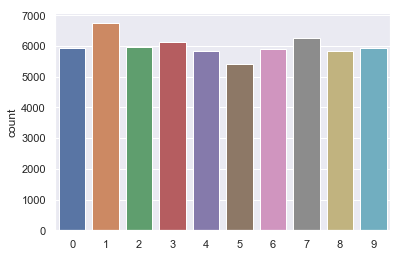

In [21]:
# lets look at the distribution of labels
sns.countplot(y_train)

#### Create a model and train it
- will use adam optimizer but could honestly stick with sgd for this simple dataset
- will use categorical cross entropy loss ("sparse" since we are not going to use one hot encoded labels)
- will use validation split : basically cross-validation 0.9 to 0.1 in the training set. 

In [22]:
from tensorflow import keras

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation

In [129]:
def save_model(model, filename):
    model.save(filename)
    return filename

In [113]:
# need to be 4d for keras models, so add a dimension = 1 and the rest is like it was before
x_train_keras = x_train_norm.reshape(x_train.shape[0], 28, 28, 1)
x_test_keras = x_test_norm.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28,28,1)
num_classes = 10


In [144]:
def plot_history(model_history):
    fig, ax = plt.subplots(figsize = (15,7), ncols = 2)
    epochs = np.linspace(1,len(model_history.history["acc"]), len(model_history.history["acc"])).astype(int)
    
    sns.lineplot(x = epochs, y = model_history.history["acc"], ax = ax[0])
    sns.lineplot(x = epochs, y = model_history.history["val_acc"], ax = ax[0])
    ax[0].set_title("Accuracy and validation accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].legend(["Train","Test"], loc = "best")
    
    sns.lineplot(x = epochs, y = model_history.history["loss"], ax = ax[1])
    sns.lineplot(x = epochs, y = model_history.history["val_loss"], ax = ax[1])
    ax[1].set_title("Accuracy and validation loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].legend(["Train","Test"], loc = "best")
    
# from keras: https://keras.io/visualization

#### A simple nn
- no dropout
- relu 
- only 2 layers including the final layer (1 hidden)
- still performs with > 0.89 accuracy on first epoch and 0.92 ish on 10th....

In [128]:
dense_net = Sequential()
dense_net.add(Dense(28, activation = tf.nn.relu))
dense_net.add(Flatten())
dense_net.add(Dense(num_classes, activation = tf.nn.softmax))

dense_net.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
dense_net_history = dense_net.fit(x = x_train_keras, y = y_train, epochs = 10, validation_split = 0.1, batch_size = 32)
dense_net.summary()

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 20s 368us/sample - loss: 0.3686 - acc: 0.8943 - val_loss: 0.2601 - val_acc: 0.9260
Epoch 2/10
54000/54000 [==============================] - 18s 338us/sample - loss: 0.2943 - acc: 0.9166 - val_loss: 0.2585 - val_acc: 0.9228
Epoch 3/10
54000/54000 [==============================] - 19s 345us/sample - loss: 0.2845 - acc: 0.9206 - val_loss: 0.2387 - val_acc: 0.9332
Epoch 4/10
54000/54000 [==============================] - 19s 346us/sample - loss: 0.2755 - acc: 0.9227 - val_loss: 0.2375 - val_acc: 0.9335
Epoch 5/10
54000/54000 [==============================] - 18s 330us/sample - loss: 0.2716 - acc: 0.9237 - val_loss: 0.2303 - val_acc: 0.9357
Epoch 6/10
54000/54000 [==============================] - 19s 350us/sample - loss: 0.2674 - acc: 0.9246 - val_loss: 0.2308 - val_acc: 0.9385
Epoch 7/10
54000/54000 [==============================] - 19s 346us/sample - loss: 0.2643 - acc: 0.9264 -

10000/10000 [==============================] - 1s 122us/sample - loss: 0.2746 - acc: 0.9262


[0.2746317294538021, 0.9262]

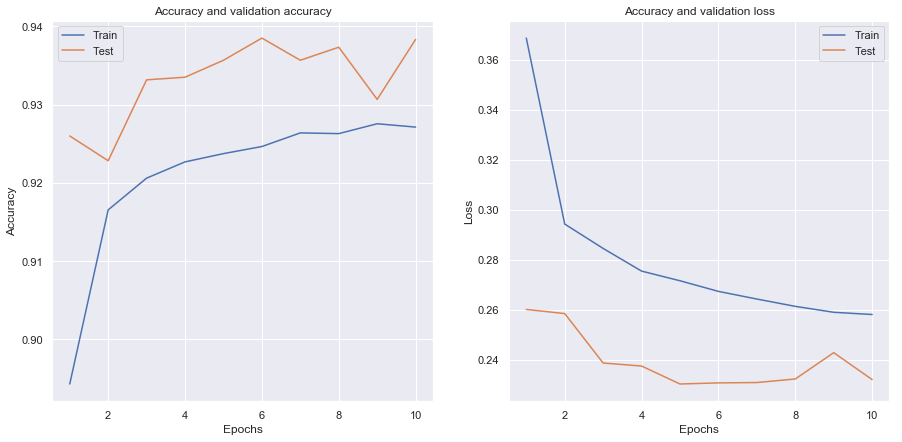

In [141]:
plot_history(dense_net_history)
save_model(dense_net, "dense_net")
dense_net.evaluate(x_test_keras, y_test)

#### A convolutional net

VGG architecture:
- https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/
- only 3×3 conv with increasing depth
- max pooling to keep volume size low
- 2 FC layers with 4096 nodes
- softmax classifier
- used for image recognition

Drawbacks:
- SLOWWWW
- lots of parameters

In [142]:
# use conv2d layers since our input is a sequence of 2d images
#  this architecture is only loosely based on vgg: basically just the main principle
conv_net = Sequential()

conv_net.add(Conv2D(64, kernel_size = (3,3)))
conv_net.add(MaxPooling2D(pool_size = (2,2)))

conv_net.add(Conv2D(128, kernel_size = (3,3)))
conv_net.add(MaxPooling2D(pool_size = (2,2)))

conv_net.add(Conv2D(256, kernel_size = (3,3)))
conv_net.add(MaxPooling2D(pool_size = (2,2)))

conv_net.add(Flatten())
conv_net.add(Dense(1024, activation = tf.nn.relu))
conv_net.add(Dense(1024, activation = tf.nn.relu))
conv_net.add(Dense(num_classes, activation = tf.nn.softmax))

In [152]:
# if labels are not one-hot encoded, use sparse categorical cross-entropy instead of just categorical cross-entropy!

#  train with only 1 epoch to spare us some time lol
conv_net.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
conv_net_history = conv_net.fit(x=x_train_keras, y = y_train, epochs = 2, validation_split = 0.1, batch_size = 32)
conv_net.summary()

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - 127s 2ms/sample - loss: 0.0651 - acc: 0.9819 - val_loss: 0.0439 - val_acc: 0.9862
Epoch 2/2
54000/54000 [==============================] - 126s 2ms/sample - loss: 0.0470 - acc: 0.9870 - val_loss: 0.0591 - val_acc: 0.9852
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           multiple                  640       
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_13 (Conv2D)           multiple                  73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_11 (F

10000/10000 [==============================] - 5s 452us/sample - loss: 0.0546 - acc: 0.9857


[0.05462352115928225, 0.9857]

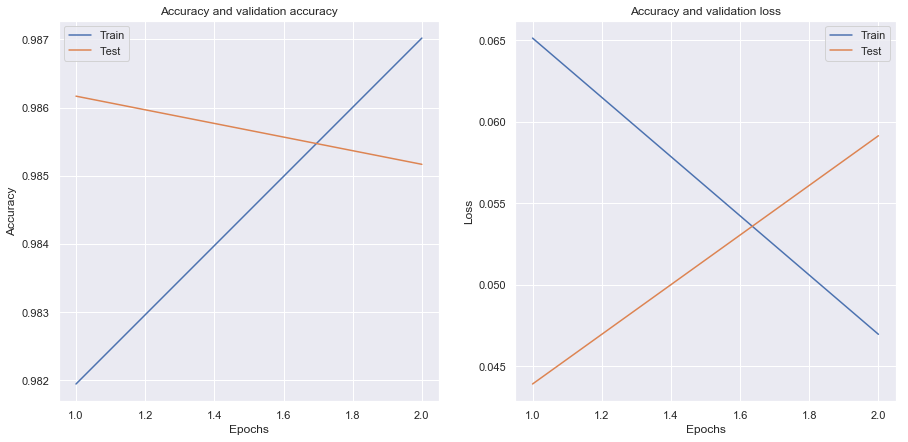

In [153]:
plot_history(conv_net_history)
save_model(conv_net, "conv_net")
conv_net.evaluate(x_test_keras, y_test)

- only 2 epochs and still manage to reach 0.98, with test 0.98 too

#### A mix of both worlds:
- 1 convolutional layer is enough
- use relu
- use dropout
- use softmax

In [155]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (2,2), input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = tf.nn.relu))
model.add(Dense(num_classes, activation = tf.nn.softmax))

In [157]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy","categorical_accuracy"])
model_history = model.fit(x_train_keras, y_train, epochs = 10, validation_split = 0.1, batch_size = 32)
model.summary()

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 22s 405us/sample - loss: 0.2137 - acc: 0.9352 - categorical_accuracy: 0.0995 - val_loss: 0.0790 - val_acc: 0.9775 - val_categorical_accuracy: 0.0977
Epoch 2/10
54000/54000 [==============================] - 23s 421us/sample - loss: 0.0814 - acc: 0.9747 - categorical_accuracy: 0.0990 - val_loss: 0.0708 - val_acc: 0.9800 - val_categorical_accuracy: 0.0968
Epoch 3/10
54000/54000 [==============================] - 23s 426us/sample - loss: 0.0549 - acc: 0.9828 - categorical_accuracy: 0.0991 - val_loss: 0.0585 - val_acc: 0.9847 - val_categorical_accuracy: 0.0973
Epoch 4/10
54000/54000 [==============================] - 23s 429us/sample - loss: 0.0395 - acc: 0.9871 - categorical_accuracy: 0.0989 - val_loss: 0.0588 - val_acc: 0.9843 - val_categorical_accuracy: 0.0973
Epoch 5/10
54000/54000 [==============================] - 23s 425us/sample - loss: 0.0319 - acc: 0.9903 - categorical_accur

10000/10000 [==============================] - 1s 110us/sample - loss: 0.0728 - acc: 0.9822 - categorical_accuracy: 0.0983


[0.07284063375153528, 0.9822, 0.0983]

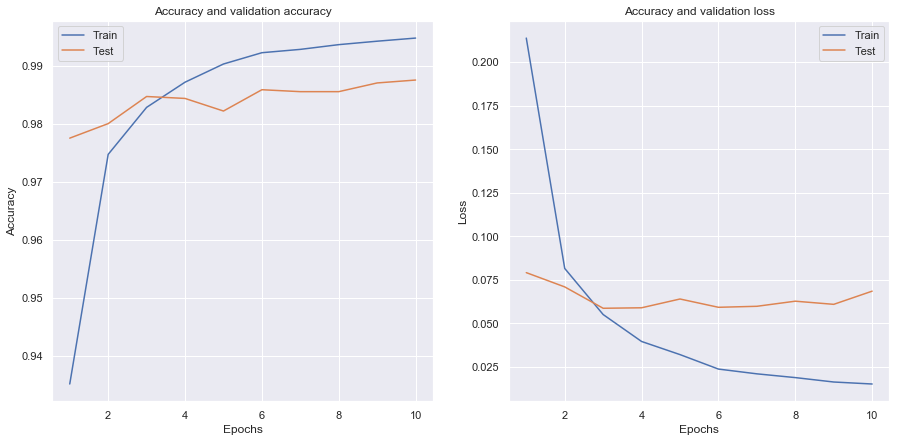

In [158]:
plot_history(model_history)
save_model(model, "model")
model.evaluate(x_test_keras, y_test)

- not as good as vgg ish conv net, but its just way faster, and seems to pick up well anyways: even though 0.93 accuracy on first epoch, peaks to 0.99 after 5 epoch and test is also 0.98...
- should really compare hyperparameters and parameters such as kernel size but meh
- also should train model a few times to get statistics on the accuracy / losses results for good practice

### fashion MNIST

In [159]:
((x_train, y_train), (x_test, y_test)) = tf.keras.datasets.fashion_mnist.load_data()


9


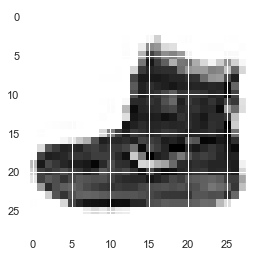

In [160]:
plt.imshow(x_train[0], cmap = "Greys")
print(y_train[0])

The classes are encoded as : (already done when loading from keras)
- 0 T-shirt/top
- 1 Trouser/pants
- 2 Pullover shirt
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

The images are in grayscale --> 0 to 255 pixel values; there are 10 categories

shamelessly going to take this from 
https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/

To start, keep in mind that the Fashion MNIST dataset is meant to be a drop-in replacement for the MNIST dataset, implying that our images have already been processed.

Each image has been:

Converted to grayscale.
Segmented, such that all background pixels are black and all foreground pixels are some gray, non-black pixel intensity.
Resized to 28×28 pixels.

In [55]:
# could redo exactly the same net as before, but could also do something else... 

Image augmentation allows us to construct “additional” training data from our existing training data by randomly rotating, shifting, shearing, zooming, and flipping.

Data augmentation is often a critical step to:

Avoiding overfitting
Ensuring your model generalizes well


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
# keras has something to do it automatically for us but we could also manually implement it
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,\
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
                         horizontal_flip=True, fill_mode="nearest")

###  CIFAR10

In [57]:
from tensorflow.keras.datasets import cifar10

In [58]:
((x_train, y_train), (x_test, y_test)) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 17s 0us/step
